# README

This takes the data generated from gen_npWindow_data.py and converts it into graphs. This experiment is taking 12 curves where there are windows around the null points. These windows around the null points are varied to show how close we need to be to the null point to have improved MSE beyond the conventional method

# Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools
import os
from matplotlib.ticker import MultipleLocator

# Initialization

In [2]:
cwd_temp = os.getcwd()
base_file = 'Stabilization'
cwd_full = cwd_temp.split(base_file, 1)[0]
print(cwd_full)

exp_file = 'npWindow_Data'
exp_date = '30Oct23'

spacing = 0.05          #how far did the windows spread around center --> 2*spacing
center_range = 0.15     #how far did we allow the spacing to go
method = "AIC"

param_oi = 2

assert(param_oi >= 0 and param_oi < 6)

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

c:\co\NIA\


In [3]:
with open(f'{cwd_full}\{base_file}\Espresso_Method\{exp_file}\hprParameter_{method}_sp_{spacing}_rng_{center_range}_{exp_date}.pkl', 'rb') as handle:
    
    dict = pickle.load(handle)
    SNR_value = dict["SNR_value"]
    rad_diff = dict['rad_diff']
    center_range = dict['center_range']
    center_diff_array = dict['center_diff_array']
    num_centers = dict['num_centers']
    true_params = dict["true_params"]
    nTE = dict["nTE"]
    dTE = dict["dTE"]
    var_reps = dict["var_reps"]
    AIC_eval_iter = dict['AIC_eval_iter']
    multi_start = dict['multi_start']
    handle.close()

T11, T12, c1, c2, T21, T22 = true_params

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

In [25]:
def to_readable(file):
    df = pd.read_pickle(file)
    ALL_CENTER = np.stack(df["Center"].values) #shape: (len(center_diff_range))
    ALL_TI = np.stack(df["TI_DATA"].values) #shape: (len(center_diff_range), len(TI))
    ALL_SNR = np.stack(df["SNR_eTime"].values) #shape: len(center_diff_range))
    ALL_MSE = np.stack(df["MSE"].values) #shape: (len(center_diff_range))
    ALL_VAR = np.stack(df["var"].values) #shape: (len(center_diff_range))

    ALL_BIAS = np.stack(df["bias"].values) #shape: (len(center_diff_range))
    ALL_AIC = np.stack(df["AIC"].values) #shape: (len(center_diff_range))

    ALL_pEst_AIC = np.stack(df["pEst_AIC"].values) #shape: (len(center_diff_range), num_iters, num_params)
    ALL_pEst_cf = np.stack(df["pEst_cf"].values) #shape: (len(center_diff_range), num_iters, num_params)
    
    return ALL_CENTER, ALL_TI, ALL_SNR, ALL_MSE, ALL_VAR, ALL_BIAS, ALL_AIC, ALL_pEst_AIC, ALL_pEst_cf


def int_lengh_AIC(R0, diff_TE, SNR):
    return (2*diff_TE/(R0*SNR**2))**(1/2)

In [26]:
def prepare_data(p_oi):

    MSE_ordered = np.zeros((len(center_diff_array),3))
    var_ordered = np.zeros((len(center_diff_array),3))
    bias_ordered = np.zeros((len(center_diff_array),3))
    AIC_ordered = np.zeros((len(center_diff_array), 12))

    SNR_ordered = np.zeros((len(center_diff_array)))
    TI_ordered = np.zeros((len(center_diff_array),12))

    data_name = f"{cwd_full}\{base_file}\Espresso_Method\{exp_file}\{'n'}pWindow_{method}_sp_{spacing}_rng_{center_range}_{exp_date}.pkl"

    print("Retrieving data for " + data_name)
    Centers, TI_DATA, SNRs, MSE, VAR, BIAS, AIC, pEst_AIC, pEst_cf = to_readable(data_name)

    for index in range(len(Centers)):

        temp_center = Centers[index]

        center_index = np.where(temp_center==center_diff_array)[0][0]

        AIC_ordered[center_index,:] = AIC[index, :]/var_reps
        MSE_ordered[center_index,:] = MSE[index,:,p_oi]
        var_ordered[center_index,:] = VAR[index,:,p_oi]
        bias_ordered[center_index,:] = BIAS[index,:,p_oi]
        SNR_ordered[center_index] = SNRs[index]
        TI_ordered[center_index,:] = TI_DATA[index,:]

    return MSE_ordered, var_ordered, bias_ordered, AIC_ordered, SNR_ordered, TI_ordered

In [27]:
MSE, var, bias, AIC, SNRs, TI_DATAs = prepare_data(param_oi)

Retrieving data for c:\co\NIA\\Stabilization\Espresso_Method\npWindow_Data\npWindow_AIC_sp_0.05_rng_0.15_30Oct23.pkl


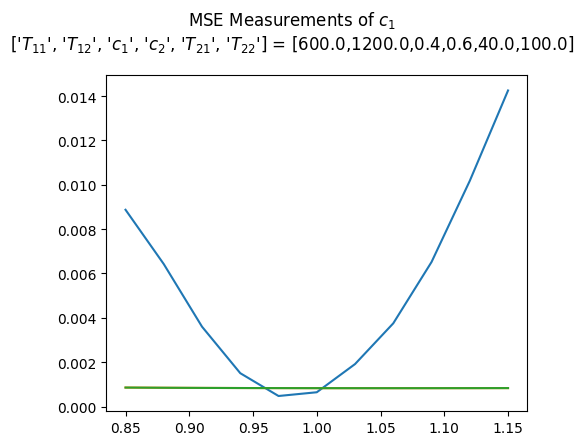

In [31]:
ordering = ["ESPRESSO", "Conventional", "Curve Fit"]

fig, ax = plt.subplots(1, 1, figsize=(5,4.5), tight_layout=True)
fig.suptitle(f"MSE Measurements of {ParamTitle_6p[param_oi]}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")
for i in range(len(ordering)):
    plt.plot(center_diff_array, MSE[:,i], label = ordering[i])


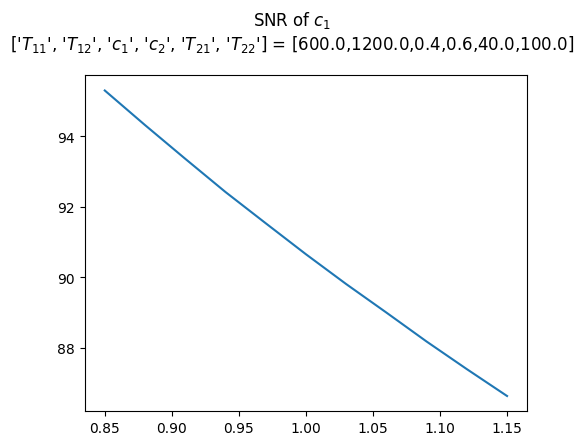

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5,4.5), tight_layout=True)
fig.suptitle(f"SNR of {ParamTitle_6p[param_oi]}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")
plt.plot(center_diff_array, SNRs, label = ordering[i])

In [18]:
interval_length_AIC_TI1 = int_lengh_AIC(R0_coeff_TI1, dTE, SNR_value)

low_AIC_TI1 = TI1star - interval_length_AIC_TI1
high_AIC_TI1 = TI1star + interval_length_AIC_TI1

interval_length_AIC_TI2 = int_lengh_AIC(R0_coeff_TI2, dTE, SNR_value)

low_AIC_TI2 = TI2star - interval_length_AIC_TI2
high_AIC_TI2 = TI2star + interval_length_AIC_TI2

In [19]:
MSE_max = np.max(MSE)
var_max = np.max(var)
biasSq_max = np.max(bias**2)

num_steps = 30
MSE_bin_array = np.arange(0, 1.05*MSE_max, MSE_max/num_steps)
var_byTI_array_bin_array = np.arange(0, 1.05*var_max, var_max/num_steps)
biasSq_bin_array = np.arange(0, 1.05*biasSq_max, biasSq_max/num_steps)

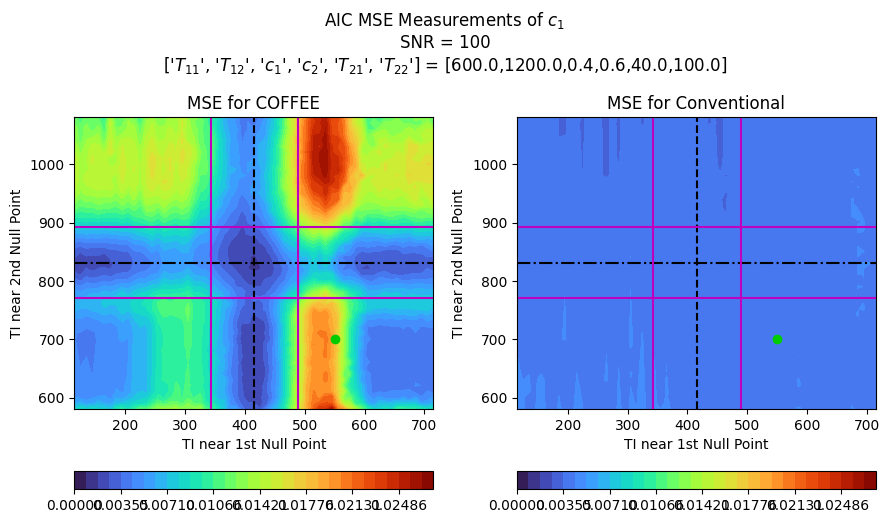

In [20]:
mTI_np1, mTI_np2 = np.meshgrid(TI1_region, TI2_region)
ordering = ["COFFEE", "Conventional", "Curve Fit"]

fig, ax = plt.subplots(1, 2, figsize=(9,5.5), tight_layout=True)
fig.suptitle(f"AIC MSE Measurements of {ParamTitle_6p[param_oi]}\nSNR = {SNR_value}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

for iter in range(2):

    cp = ax[iter].contourf(mTI_np1, mTI_np2, MSE[:,:,iter], levels = MSE_bin_array, cmap = 'turbo')
    cb = fig.colorbar(cp, ax = ax[iter], location = 'bottom')
    # cb.locator = MultipleLocator(10**(np.floor(np.log10(MSE_max))-1))
    # cb.update_ticks()

    ax[iter].axhline(y = TI2star, color = 'k', ls = '-.', label = 'Null Point 2')
    ax[iter].axvline(x = TI1star, color = 'k', ls = '--', label = 'Null Point 1')
    # ax[iter].plot(mTI_np1, mTI_np2, ls = '', marker = 'o', color = 'g')
    ax[iter].axhline(y = low_AIC_TI2, color = 'm')
    ax[iter].axhline(y = high_AIC_TI2, color = 'm')
    ax[iter].axvline(x = low_AIC_TI1, color = 'm')
    ax[iter].axvline(x = high_AIC_TI1, color = 'm')

    ax[iter].set_xlabel('TI near 1st Null Point')
    ax[iter].set_ylabel('TI near 2nd Null Point')
    ax[iter].set_title(f'MSE for {ordering[iter]}')

point_oi_x = 550
point_oi_y = 700
ax[0].plot(point_oi_x, point_oi_y, marker = 'o', ls = '', color = [0,0.8,0])
ax[1].plot(point_oi_x, point_oi_y, marker = 'o', ls = '', color = [0,0.8,0])

Text(0.75, -0.05, 'Conventional\nSuperior')

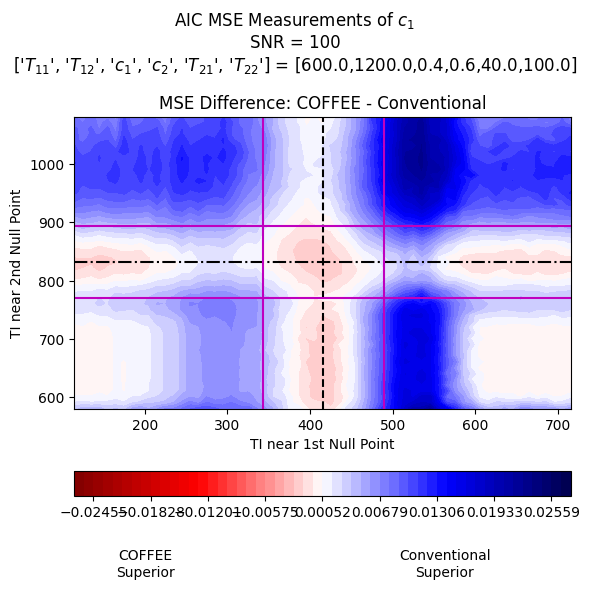

In [21]:
mTI_np1, mTI_np2 = np.meshgrid(TI1_region, TI2_region)
ordering = ["COFFEE", "Conventional", "Curve Fit"]

num_steps = 51
MSE_diff_array = np.arange(-1*MSE_max, 1.05*MSE_max, 2*MSE_max/num_steps)

fig, ax = plt.subplots(1, 1, figsize=(6,5.5), tight_layout=True)
fig.suptitle(f"AIC MSE Measurements of {ParamTitle_6p[param_oi]}\nSNR = {SNR_value}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")


cp = ax.contourf(mTI_np1, mTI_np2, MSE[:,:,0] - MSE[:,:,1], levels = MSE_diff_array, cmap = 'seismic_r')
cb = fig.colorbar(cp, ax = ax, location = 'bottom')
# cb.locator = MultipleLocator(10**(np.floor(np.log(MSE_max))))
# cb.update_ticks()

ax.axhline(y = TI2star, color = 'k', ls = '-.', label = 'Null Point 2')
ax.axvline(x = TI1star, color = 'k', ls = '--', label = 'Null Point 1')

ax.axhline(y = low_AIC_TI2, color = 'm')
ax.axhline(y = high_AIC_TI2, color = 'm')
ax.axvline(x = low_AIC_TI1, color = 'm')
ax.axvline(x = high_AIC_TI1, color = 'm')
# ax[iter].plot(mTI_np1, mTI_np2, ls = '', marker = 'o', color = 'g')

ax.set_xlabel('TI near 1st Null Point')
ax.set_ylabel('TI near 2nd Null Point')
ax.set_title(f'MSE Difference: COFFEE - Conventional')
fig.text(0.25, -0.05,"COFFEE\nSuperior", ha='center')
fig.text(0.75, -0.05,"Conventional\nSuperior", ha='center')

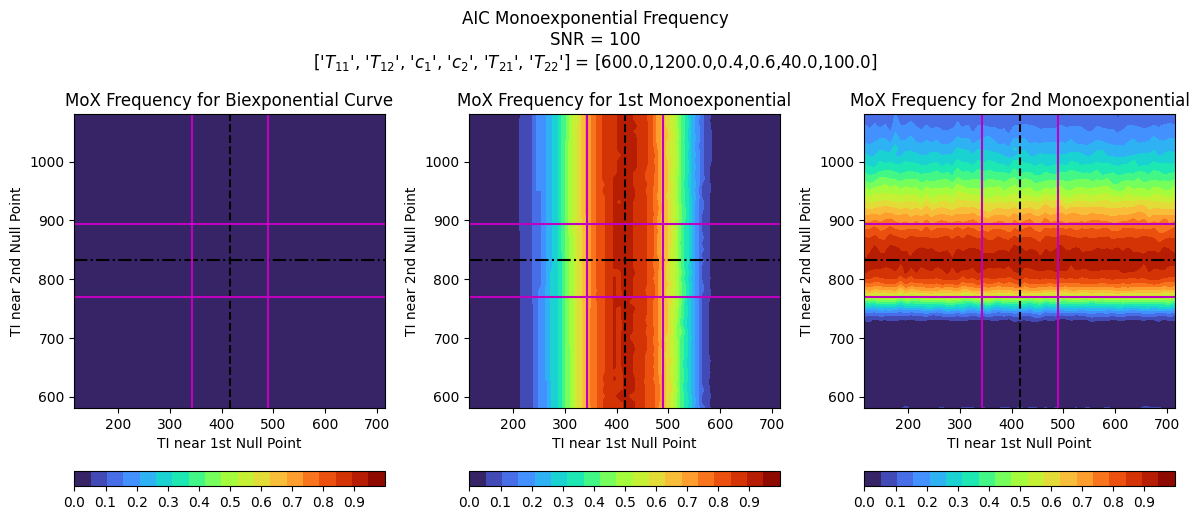

In [22]:
mTI_np1, mTI_np2 = np.meshgrid(TI1_region, TI2_region)
ordering = ["Biexponential Curve", "1st Monoexponential", "2nd Monoexponential"]

fig, ax = plt.subplots(1, 3, figsize=(12,5.5), tight_layout=True)
fig.suptitle(f"AIC Monoexponential Frequency\nSNR = {SNR_value}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

num_steps = 20
freq_array = np.arange(0, 1.00, 1.05/num_steps)

for iter in range(3):

    cp = ax[iter].contourf(mTI_np1, mTI_np2, AIC[:,:,iter], levels = freq_array, cmap = 'turbo')
    cb = fig.colorbar(cp, ax = ax[iter], location = 'bottom')
    cb.locator = MultipleLocator(0.1)
    cb.update_ticks()

    ax[iter].axhline(y = TI2star, color = 'k', ls = '-.', label = 'Null Point 2')
    ax[iter].axvline(x = TI1star, color = 'k', ls = '--', label = 'Null Point 1')

    ax[iter].axhline(y = low_AIC_TI2, color = 'm')
    ax[iter].axhline(y = high_AIC_TI2, color = 'm')
    ax[iter].axvline(x = low_AIC_TI1, color = 'm')
    ax[iter].axvline(x = high_AIC_TI1, color = 'm')
    # ax[iter].plot(mTI_np1, mTI_np2, ls = '', marker = 'o', color = 'g')

    ax[iter].set_xlabel('TI near 1st Null Point')
    ax[iter].set_ylabel('TI near 2nd Null Point')
    ax[iter].set_title(f'MoX Frequency for {ordering[iter]}')

In [28]:
threshold = 0.01

dang_ind = ((MSE[:,:,0] - MSE[:,:,1])>threshold)
print(dang_ind.shape)


(51, 61)


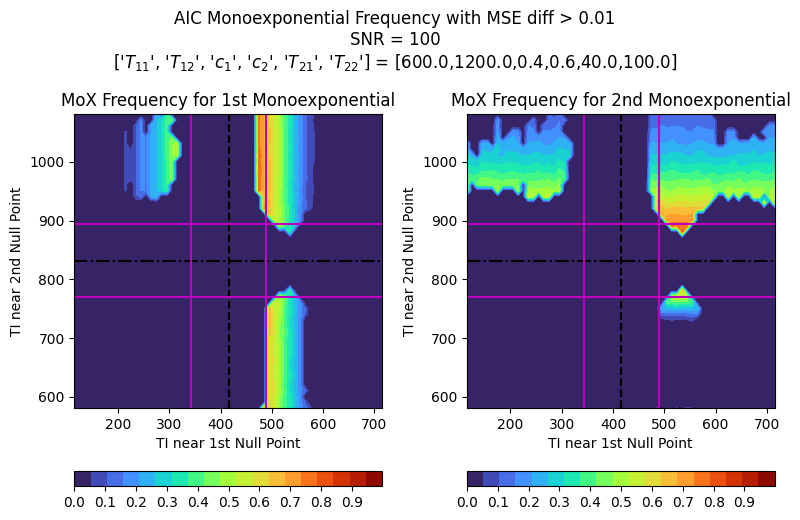

In [33]:

mTI_np1, mTI_np2 = np.meshgrid(TI1_region, TI2_region)
ordering = ["Biexponential Curve", "1st Monoexponential", "2nd Monoexponential"]

fig, ax = plt.subplots(1, 2, figsize=(8,5.5), tight_layout=True)
fig.suptitle(f"AIC Monoexponential Frequency with MSE diff > {threshold}\nSNR = {SNR_value}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

num_steps = 20
freq_array = np.arange(0, 1.00, 1.05/num_steps)

for iter in range(2):
    
    cp = ax[iter].contourf(mTI_np1, mTI_np2, AIC[:,:,iter+1]*dang_ind, levels = freq_array, cmap = 'turbo')
    cb = fig.colorbar(cp, ax = ax[iter], location = 'bottom')
    cb.locator = MultipleLocator(0.1)
    cb.update_ticks()

    ax[iter].axhline(y = TI2star, color = 'k', ls = '-.', label = 'Null Point 2')
    ax[iter].axvline(x = TI1star, color = 'k', ls = '--', label = 'Null Point 1')

    ax[iter].axhline(y = low_AIC_TI2, color = 'm')
    ax[iter].axhline(y = high_AIC_TI2, color = 'm')
    ax[iter].axvline(x = low_AIC_TI1, color = 'm')
    ax[iter].axvline(x = high_AIC_TI1, color = 'm')
    # ax[iter].plot(mTI_np1, mTI_np2, ls = '', marker = 'o', color = 'g')

    ax[iter].set_xlabel('TI near 1st Null Point')
    ax[iter].set_ylabel('TI near 2nd Null Point')
    ax[iter].set_title(f'MoX Frequency for {ordering[iter+1]}')